# Laboratory exercise - Information processing - Neural networks
###   Jaime Rodriguez

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

from torchsummary import summary

import cv2
import numpy as np
import matplotlib.pyplot as plt

import pickle

# Task 1 - Classification of the image of handwritten digits

In the first task of this laboratory exercise, we want to analyze the impact of network architecture and other hyperparameters on prediction performance. Your task is to put together several models with different characteristics, and you will train these models on the problem of classifying handwritten digits.

Much of the code needed to conduct the exercise is given. You will solve the task by filling in the missing parts. You are also free to modify the suggested code, but it is not recommended. The lab requires Python 3.6+ and PyTorch 1.6+.

## Data loading

The following code prepares the MNIST Dataset that come with the PyTorch package. We also instantiate DataLoader objects that handle mixing and batching a set of data.

In [7]:
batch_size_train = 64
batch_size_test = 64

train_set = torchvision.datasets.MNIST('./files/', train=True, download=True,
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                                      )


test_set = torchvision.datasets.MNIST('./files/', train=False, download=True,
                                      transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                                     )

In [8]:
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=True)

#### Task a)
Show a few examples from the test suite. Show the image using the `matplotlib` function` imshow`. Let the `title` of the displayed image be the label of the sample.

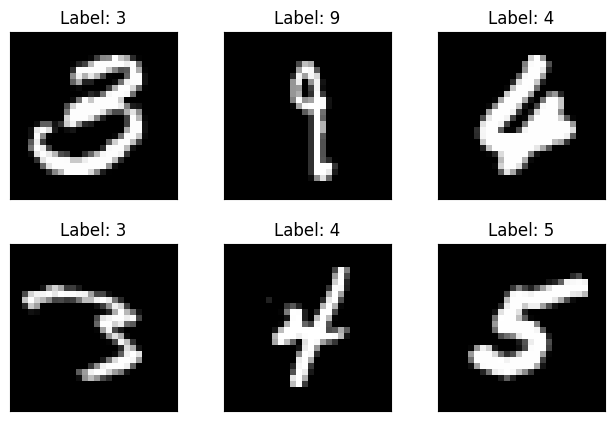

In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    # ----
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Label: {}".format(example_targets[i]))
    # ----
    plt.xticks([])
    plt.yticks([])

plt.show()

## Helper functions for training neural networks

After the subtasks of this section, there is a set of tests on which you can check the accuracy of your helper functions. Without properly working helper functions, you won't be able solve the rest of the lab.

#### Task b) - Function for counting the number of parameters in a PyTorch model

One of the methods of comparing our models will be by the number of parameters that make up that model. Therefore, it is necessary to write the method `get_number_of_model_parameters (model)` which for the submitted model `model` returns the total number of parameters of that model.
Each PyTorch model contains an implementation of the `.parameters()` method that returns an iterator over the model parameters. These parameters are of type `torch.nn.parameter.Parameter`, whose dimensions can be obtained using the` .shape` property.
Complete the required method.

In [14]:
def get_number_of_model_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # numel() returns the total number of elements contained in that parameter ex. 3x3 -> 9

#### Task c) - Train step function

Model is trained in four steps.

1. The feed-foward result is calculated for one batch.
2. Based on the output obtained and the correct label, the loss is calculated.  As shown in the demonstration notebook, the NLLLoss paired with the "log_softmax" activation is equivalent to the categorical cross-entropy loss shown in the lecture.
3. The calculated error is propagated backwards through the network to calculate the gradients.
4. Based on the gradients, parameter values and optimizer parameters (which optimizer is used, what is the learning rate, momentum, etc.), the new value of the model parameters is calculated.

Implement these steps in the `train_step (network, train_loader, epoch, device, verbose)` function.

Notes:
* The error you need to calculate is "negative log likelihood loss", for which PyTorch offers an implementation. We recommend that you use a ready-made implementation of the loss function.
* Calculating gradients using backward propagation is calculated using the `.backward()` method. Over which element do we invoke this method?
* The optimization step is done using the `.step()` object optimizer method. Suppose there is an `optimizer` object in the global scope.
* Be careful that your gradients do not accumulate through multiple optimization steps. PyTorch models offer the `.zero_grad()` method, which sets the values of all gradients of a model to 0.


In [16]:
def train_step(network, train_loader, epoch, device, verbose=True):
    train_losses = []
    train_counter = []

    network.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        # 1 --- Feed-fordward
        output = network(data)

        # 2 --- Loss
        loss = F.nll_loss(output, target)

        # 3 --- Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # 4 --- Update parameters
        optimizer.step()

        if (batch_idx % log_interval == 0):
            if verbose:
                print('Train Epoch: {:5d} [{:5d}/{:5d} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item()))

            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

    return train_losses, train_counter

#### Task d) - Function for model evaluation

Learning success is determined using accuracy metrics. In this lab exercise, we follow two metrics - `negative log likelihood` and` accuracy`. We have already seen NLLLoss; accuracy is defined as:

$ accuracy = \frac{\text{number of correctly classified samples}}{\text{total number of samples}} $

Complete the `test (network, test_loader, device, verbose)` function so that the model is evaluated for the specified metrics.

The suggested code uses `with torch.no_grad()`. As we do not change the parameters of the model during the evaluation, we do not need a gradient. This speeds up the calculation (the gradient is not calculated), saves memory (the calculated gradient is not saved) and prevents future problems (eg gradients remain until the next phase of training, where the test set gradients are used for learning).

In [18]:
def test(network, test_loader, device, verbose=True):
    network.eval()

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            # -----
            # Feed-fordward
            output = network(data)
            # Compute NNL loss for the batch, with 'sum' we add the loss across all samples in the batch
            test_loss += F.nll_loss(output, target, reduction = 'sum').item()
            # Get the index of the predicted class
            pred = output.argmax(dim=1, keepdim=True)
            # Count correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()
            # -------

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    if verbose:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {:5d}/{:5d} ({:2.2f}%)\n'.format(
            test_loss,
            correct,
            len(test_loader.dataset),
            accuracy))

    return test_loss, accuracy

In the next phase of laboratory exercises, we perform experiments, save the results and compare. We will save the results in the `results` folder, so that the` key` of the folder will be the name of the experiment, and the value will be `tuple`, which contains the values by which the model is compared.

In [20]:
results = dict()

#### Task e) - Function for execution of an entire experiment

Now is the time to consolidate the steps from the previous subtasks. The function `train_network (network, train_loader, test_loader, device)` works on the following principle:

* It is assumed that in the global scope there is a variable named `n_epochs` that tells us how many epochs the experiment will run
* The `train_losses` and` test_losses` lists collect loss values during training, while `train_counter` and` test_counter` collect moments when metrics were recorded (in other words, these are the X and Y axes on the "loss by time" graph)
* before the training itself, the model is tested to determine the performance of a random model
* In each epoch, the model is trained, tested and the results are recorded in the appropriate lists
* The function returns those lists at the end

In [22]:
def train_network(network, train_loader, test_loader, device='cpu'):
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    # -----
    test_loss, test_accuracy = test(network, test_loader, device)
    # -------------
    test_losses.append(test_loss)

    for epoch in range(1, n_epochs + 1):
        # ----
        new_train_losses, new_train_counter = train_step(network, train_loader, epoch, device)
        test_loss, test_accuracy = test(network, test_loader, device)
        # ---------

        train_losses.extend(new_train_losses)
        train_counter.extend(new_train_counter)
        test_losses.append(test_loss)

    return train_losses, train_counter, test_losses, test_counter, test_accuracy

#### Tests to evaluate the functionality of the helper functions

The following code serves as an aid to verify the correctness of the above helper functions. A dataset is generated in two separate sets, and the goal is to learn a model that classifies from which set the point comes. First we generate the data and compile the DataLoader:

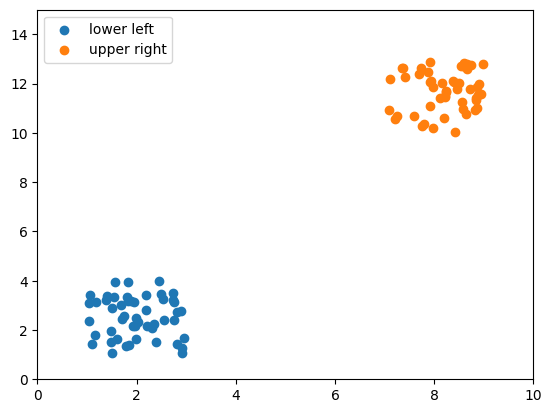

In [25]:
data_x = np.hstack([np.random.uniform(1, 3, 50), np.random.uniform(7, 9, 50)])
data_y = np.hstack([np.random.uniform(1, 4, 50), np.random.uniform(10, 13, 50)])
labels = [0 if x < 50 else 1 for x in range(0, 100)]

for idx, unique_label in enumerate(["lower left", "upper right"]):
    if idx == 0:
        plt.scatter(data_x[0:50], data_y[0:50], label=unique_label)
    if idx == 1:
        plt.scatter(data_x[50:], data_y[50:], label=unique_label)

plt.legend()
plt.xlim(0, 10)
plt.ylim(0, 15)


tensor_x = torch.Tensor(np.dstack([data_x, data_y]).reshape(100, 2).astype(np.float32))
tensor_y = torch.Tensor(labels).to(dtype=torch.int64)

toy_dataset = TensorDataset(tensor_x, tensor_y)
toy_dataloader = DataLoader(toy_dataset, batch_size=1, shuffle=True)

We then define our model. In this case, the model is a two-layer network with two fully-connected layers.

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

We adjust the parameters that our helper functions expect, and we instantiate the model and the optimizer.

In [29]:
n_epochs = 30
learning_rate = 0.01
log_interval = 33

network = Net().to('cpu')
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

And now we can train our model. Your functions are correct if the accuracy reaches 100% (or at least very close). **Without the correct helper functions you will not be able to solve the rest of the lab.**

In [31]:
_ = train_network(network, toy_dataloader, toy_dataloader, 'cpu')


Test set: Avg. loss: 0.8268, Accuracy:    50/  100 (50.00%)

Train Epoch:     1 [    0/  100 ( 0%)]	Loss: 1.446676
Train Epoch:     1 [   33/  100 (33%)]	Loss: 0.385027
Train Epoch:     1 [   66/  100 (66%)]	Loss: 1.023548
Train Epoch:     1 [   99/  100 (99%)]	Loss: 0.467233

Test set: Avg. loss: 0.7267, Accuracy:    50/  100 (50.00%)

Train Epoch:     2 [    0/  100 ( 0%)]	Loss: 1.047182
Train Epoch:     2 [   33/  100 (33%)]	Loss: 0.946997
Train Epoch:     2 [   66/  100 (66%)]	Loss: 0.900171
Train Epoch:     2 [   99/  100 (99%)]	Loss: 0.555792

Test set: Avg. loss: 0.7040, Accuracy:    50/  100 (50.00%)

Train Epoch:     3 [    0/  100 ( 0%)]	Loss: 0.462172
Train Epoch:     3 [   33/  100 (33%)]	Loss: 0.541147
Train Epoch:     3 [   66/  100 (66%)]	Loss: 0.856996
Train Epoch:     3 [   99/  100 (99%)]	Loss: 0.617671

Test set: Avg. loss: 0.6931, Accuracy:    50/  100 (50.00%)

Train Epoch:     4 [    0/  100 ( 0%)]	Loss: 0.613434
Train Epoch:     4 [   33/  100 (33%)]	Loss: 0.638

## Experiments and result analysis

#### Task f) - Experiments

The next phase of the lab is to use our functions within the experiments. The following models need to be tested:

* **Shallow model with narrow layers**
    * The model is shallow in that there are not many layers and narrow in that the layers themselves do not have a large number of elements (eg 1 layer with 100 neurons instead of 10 layers with 10 neurons)
    * The model architecture is as follows:
        * Convolutional layer 5x5x10
        * Dropout (for regularization)
        * Max pooling
        * ReLU activation
        * Fully connected layer with 20 neurons, ReLU activation
        * Fully connected layer for classification into 10 classes, log softmax activation function
    * In the `results` dictionary it is saved under the key `shallow_and_narrow_{learning rate}`


* **Shallow model with wide layers**
    * This model also doesn't have a lot of layers, but those layers have a lot of elements
    * The model architecture is as follows:
        * Convolutional layer 5x5x40
        * Dropout (for regularization)
        * Max pooling
        * ReLU activation
        * Fully connected layer with 64 neurons, ReLU activation
        * Fully connected layer for classification into 10 classes, log softmax activation function
    * In the `results` dictionary it is saved under the key `shallow_and_wide_{learning rate} `
* **Deep model with narrow layers**
    * This model has a lot of layers, but these layers are limited in their width
    * The model architecture is as follows:
        * Convolution layer 5x5x10, ReLU activation function
        * Max pooling
        * Convolution layer 5x5x20, ReLU activation function
        * Max pooling
        * Fully connected layer with 64 neurons, ReLU activation
        * Dropout (for regularization)
        * Fully connected layer for classification into 10 classes, log softmax activation function
    * In the `results` dictionary it is saved under the `deep_and_narrow_{learning rate}` key
* **Deep model with wide layers**
    * A model that has all the components well (or too much?) Represented.
    * The model architecture is as follows:
        * Convolution layer 5x5x32, ReLU activation function
        * Max pooling
        * Convolution layer 5x5x64, ReLU activation function
        * Max pooling
        * Fully connected layer with 50 neurons, ReLU activation
        * Dropout (for regularization)
        * Fully connected layer for classification into 10 classes, log softmax activation function
    * In the `results` dictionary, it is saved under the` deep_and_wide_ {learning rate} `key


Implement the `.__ init __ (self)` and `.forward (self, x)` methods for each of the described models, train them, evaluate and save the metrics. **Repeat this procedure for 3 different learning rates: 0.0000001, 0.01 and 1.**

You can find all the necessary layers for the realization of the mentioned models in the torch.nn module. Details can be found in the official PyTorch documentation: https://pytorch.org/docs/stable/index.html

**Save the best model. It will be needed in subtask h)**.

The parameters need to be adjusted first. The parameters are as follows:
* n_epochs - number of experiment epochs
* learning_rate - learning rate
* log_interval - number of steps between two prints during training (printing only happens if the function is called with the verbose = True argument)
* device - a mark on which device the experiment is performed; "miracles" for GPU, "cpu" for CPU

In [35]:
n_epochs = 3
learning_rate = 0.01
log_interval = 100
device = "cuda" if torch.cuda.is_available() else "cpu"

We define our model in the class "Net" which inherits nn.Module. Override the methods `__init __ (self)` and `forward (self, x)` as described in the task text.

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ShallowNarrowModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.dropout = nn.Dropout(p=0.3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features=10 * 12 * 12, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=10)

    def forward(self, x):
        x = self.conv(x)
        x = self.dropout(x)
        x = self.pool(x)
        x = self.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


class ShallowWideModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=40, kernel_size=5)
        self.dropout = nn.Dropout(p=0.3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features=40 * 12 * 12, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = self.conv(x)
        x = self.dropout(x)
        x = self.pool(x)
        x = self.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


class DeepNarrowModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features=20 * 4 * 4, out_features=64)
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


class DeepWideModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features=64 * 4 * 4, out_features=50)
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In order to train our model, it is necessary to create a network instance and an optimizer. Use the Stohastic Gradient Descent optimizer from the torch.optim module. Details can be found in the official PyTorch documentation for the optim module: https://pytorch.org/docs/stable/optim.html

In [39]:
models = [ShallowNarrowModel(), ShallowWideModel(), DeepNarrowModel(), DeepWideModel()]
learning_rates = [0.0000001, 0.01, 1]

# for model in models:
#     for learning_rate in learning_rates:
#         network = model.to(device)
#         optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=0.9)

#         train_losses, train_counter, test_losses, test_counter, test_accuracy = train_network(network, train_loader, test_loader, device)
#         results[f'{model.__class__.__name__}_{learning_rate}'] = {
#          'train_counter' : train_counter,
#          'train_losses' : train_losses,
#          'test_counter' : test_counter,
#          'test_losses' : test_losses,
#          'test_accuracy' : test_accuracy,
#          'number_of_parameters' : get_number_of_model_parameters(model)
#          }


# TRAINED IN GOOGLE COLAB

In [40]:
with open("results.pkl", "rb") as f:
    results = pickle.load(f)

print(results.keys()) 

dict_keys(['ShallowNarrowModel_1e-07', 'ShallowNarrowModel_0.01', 'ShallowNarrowModel_1', 'ShallowWideModel_1e-07', 'ShallowWideModel_0.01', 'ShallowWideModel_1', 'DeepNarrowModel_1e-07', 'DeepNarrowModel_0.01', 'DeepNarrowModel_1', 'DeepWideModel_1e-07', 'DeepWideModel_0.01', 'DeepWideModel_1'])


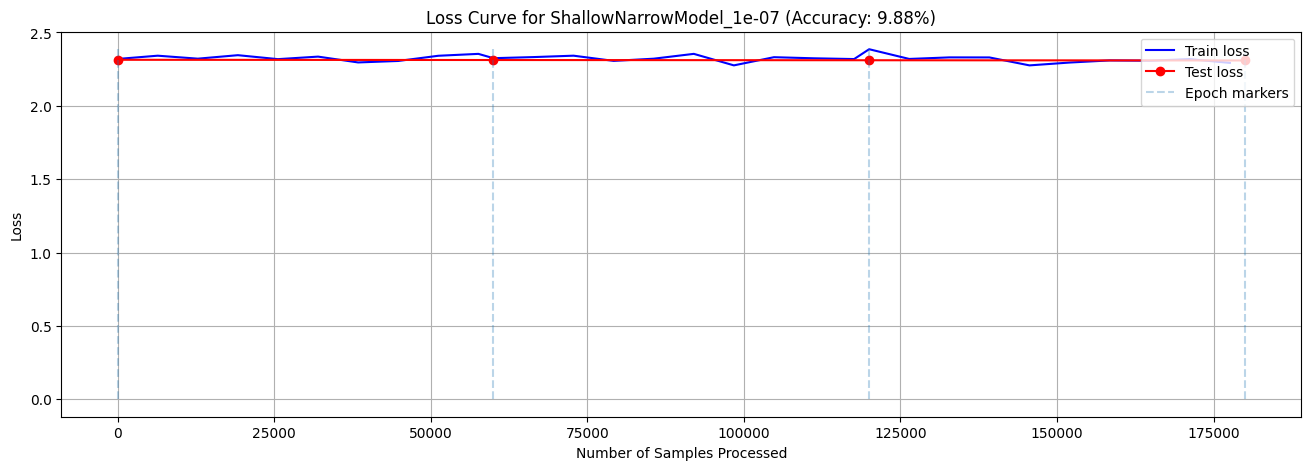

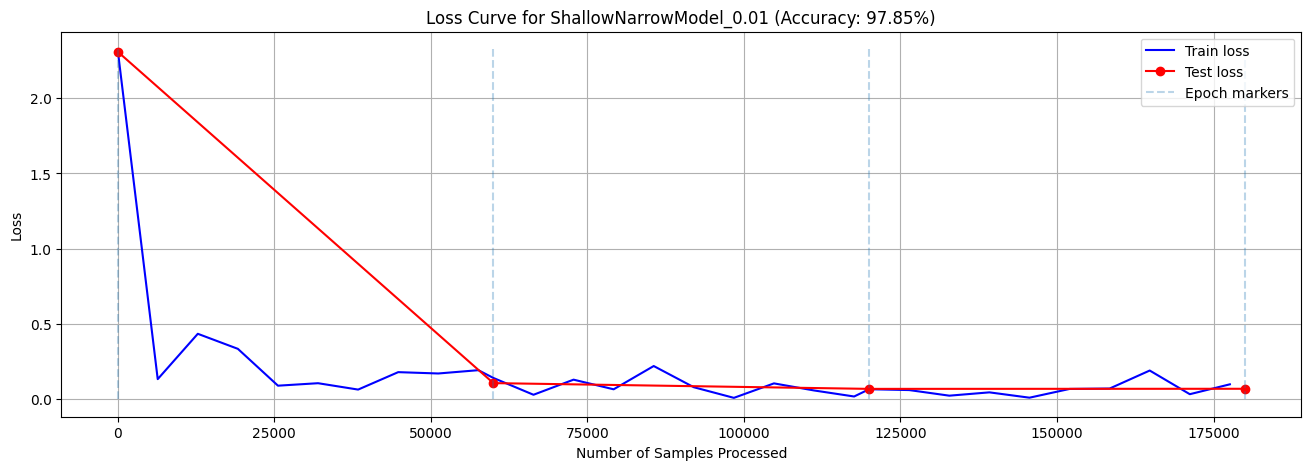

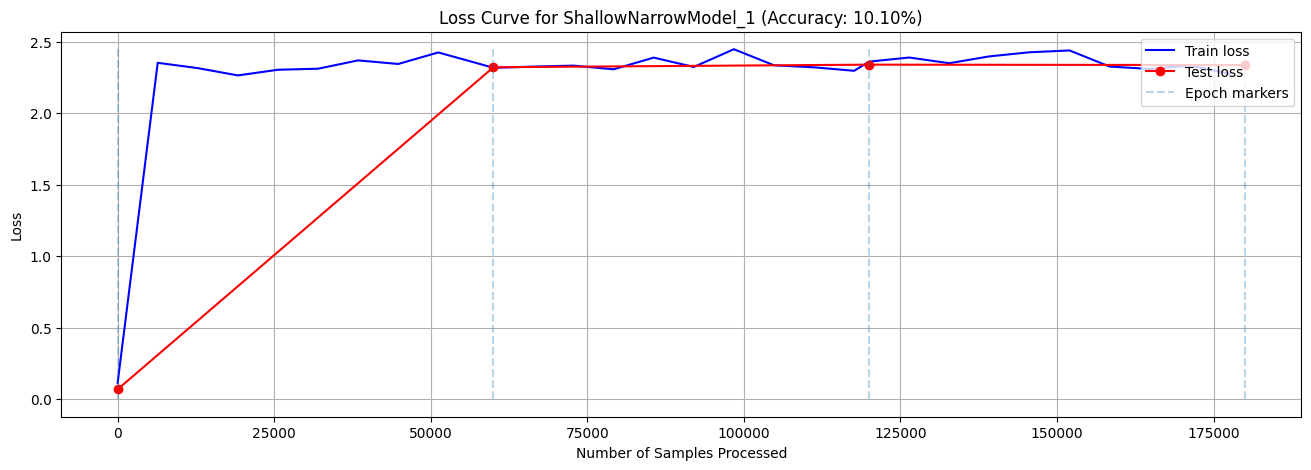

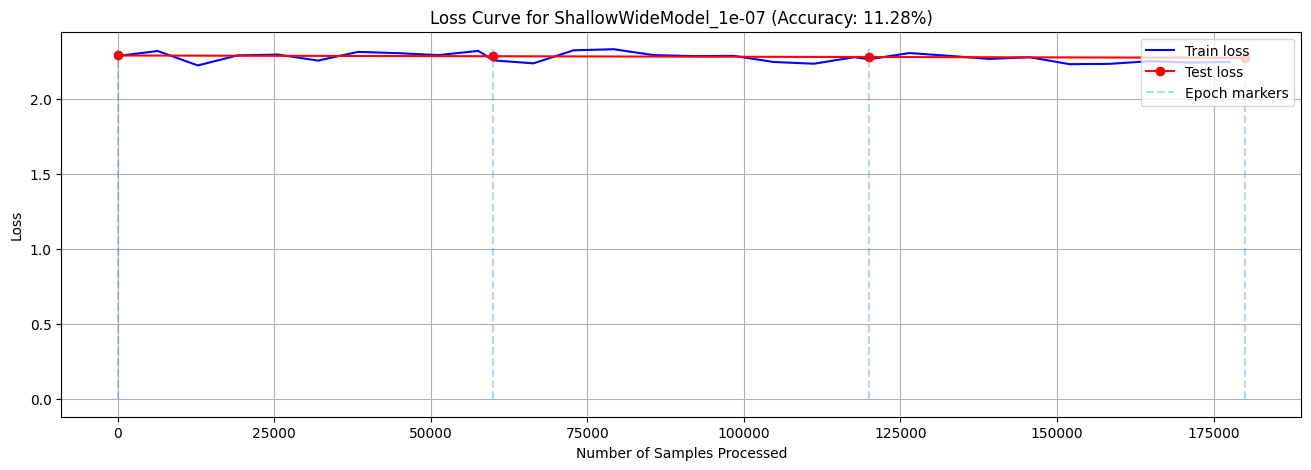

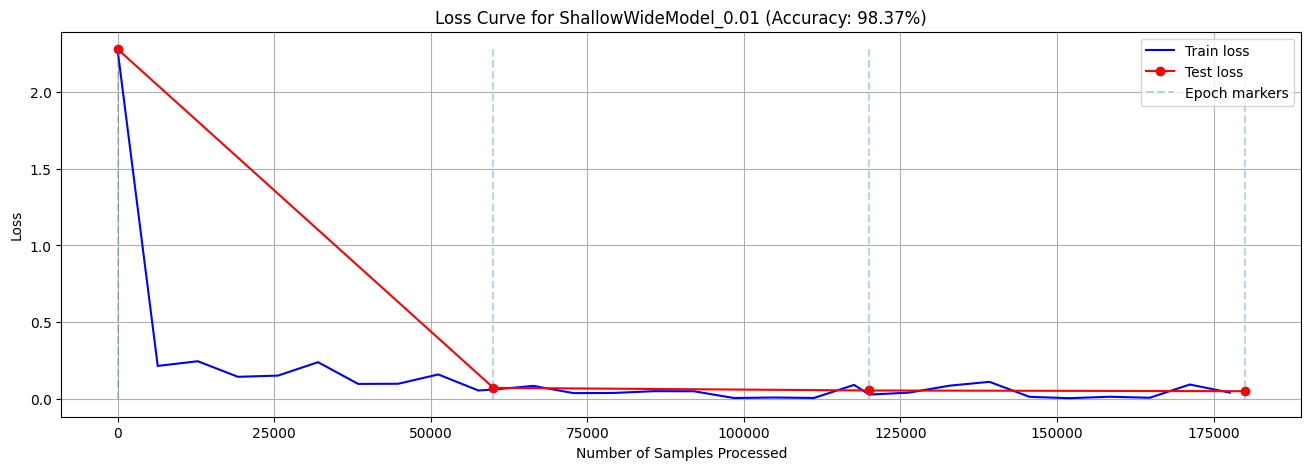

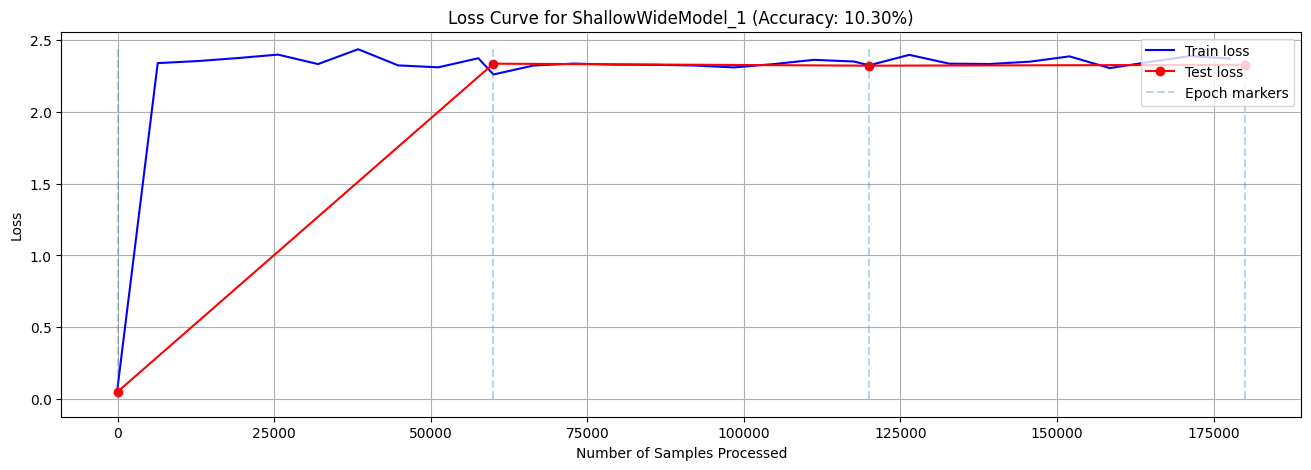

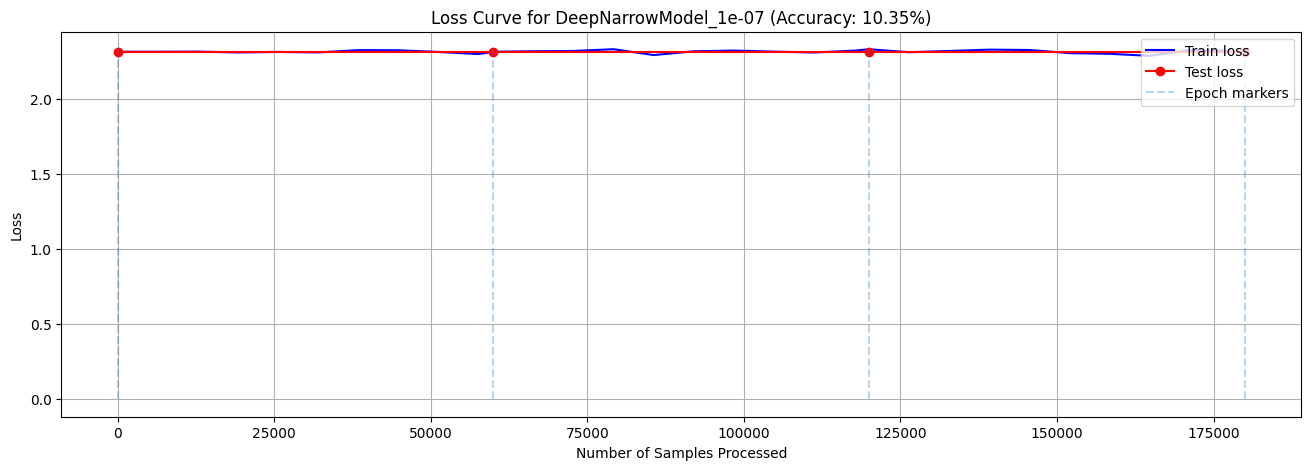

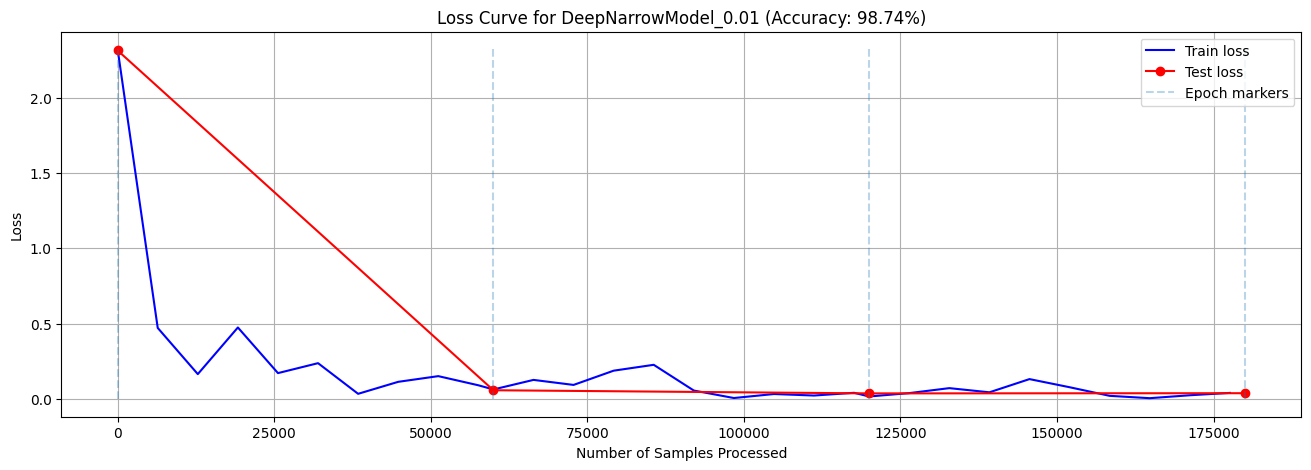

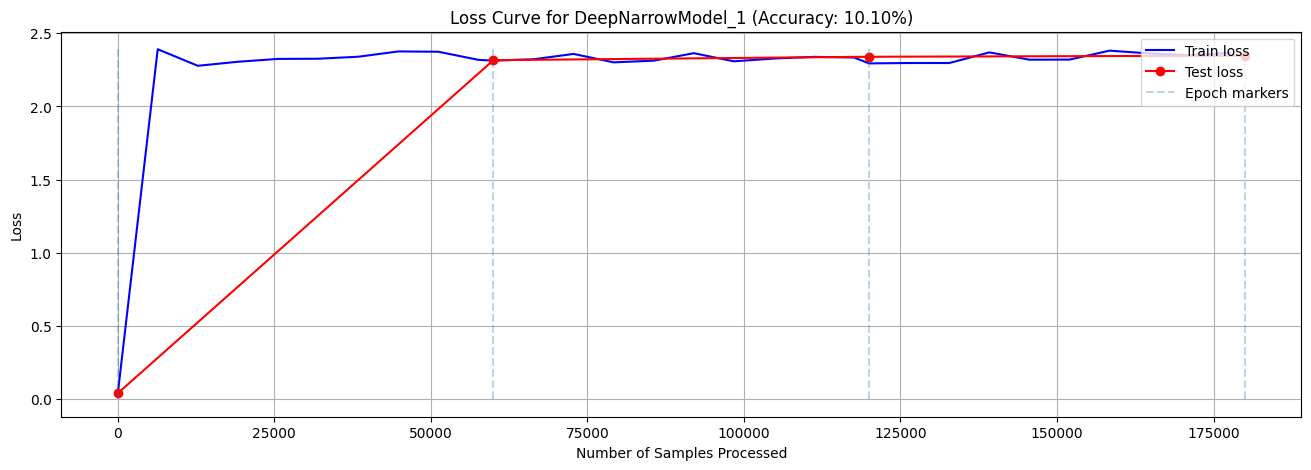

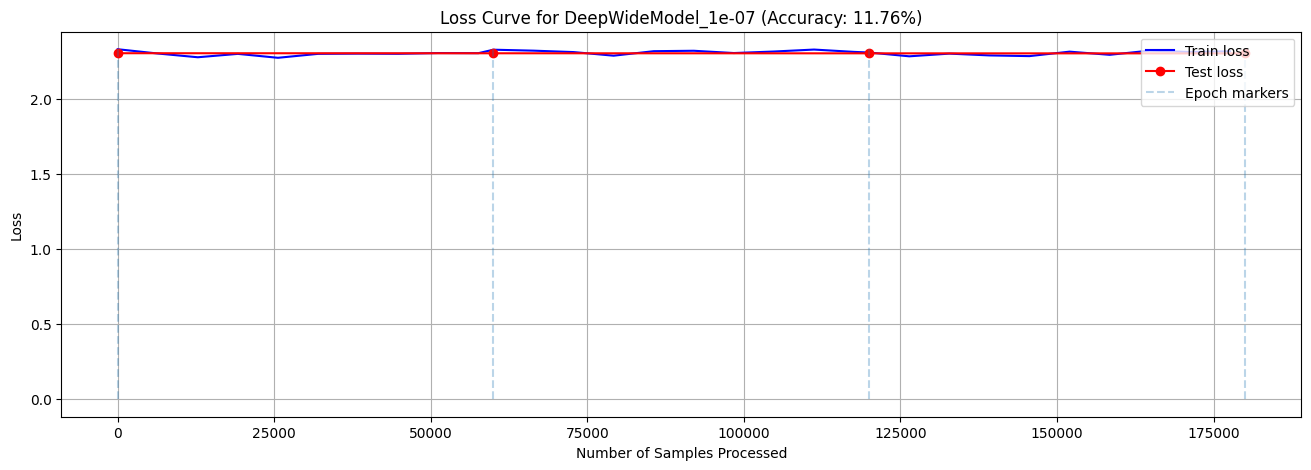

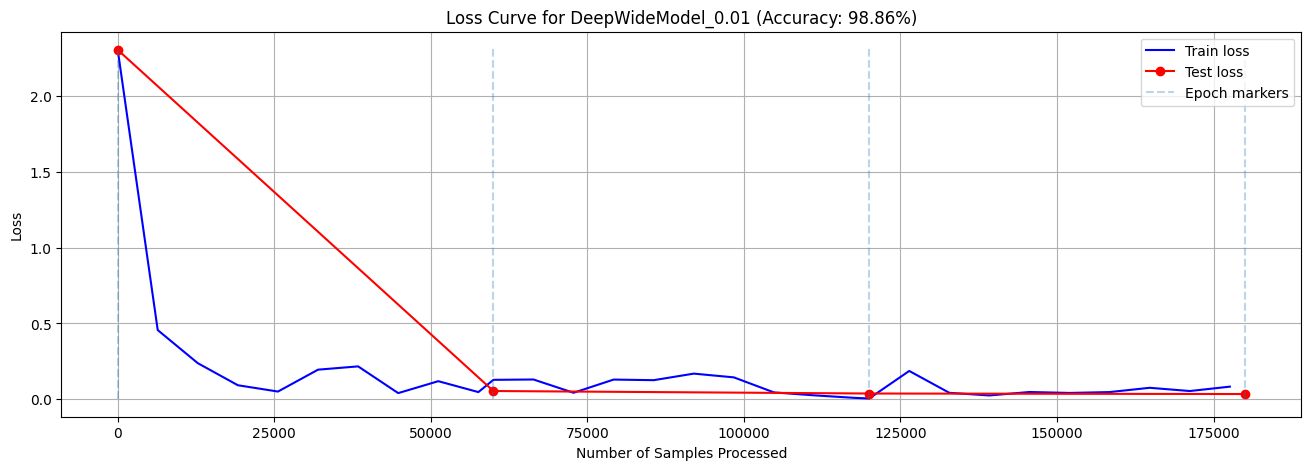

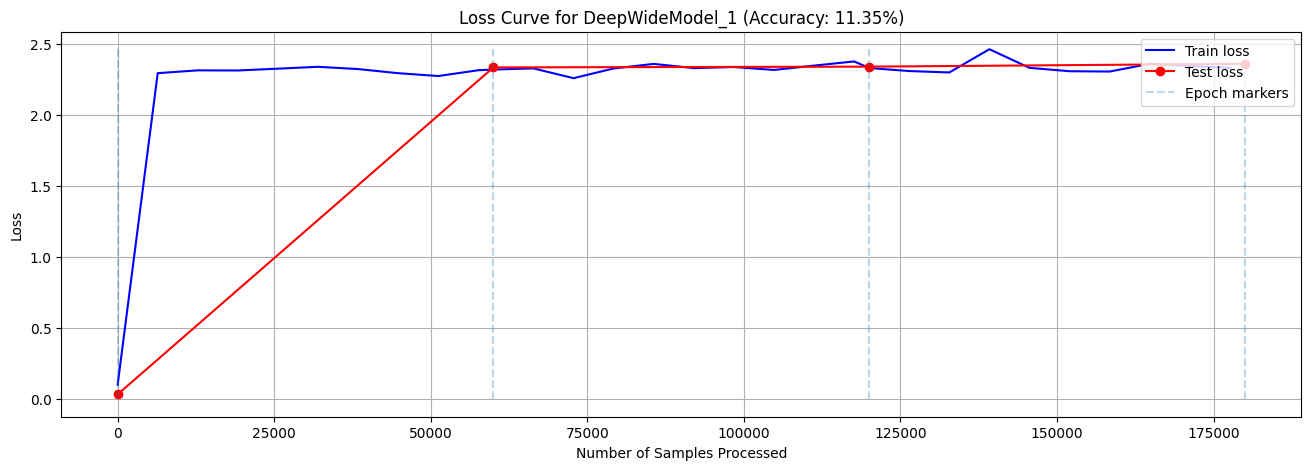

In [41]:
for model_name, model_data in results.items():
    train_losses = model_data['train_losses']
    train_counter = model_data['train_counter']
    test_losses = model_data['test_losses']
    test_counter = model_data['test_counter']

    # Create a new figure for each model
    fig = plt.figure(figsize=(16, 5))
    plt.plot(train_counter, train_losses, color='blue', label='Train loss')
    plt.plot(test_counter, test_losses, color='red', marker='o', label='Test loss')

    # Optional: draw vertical lines at each test step
    y_max = max(train_losses + test_losses)
    plt.vlines(test_counter, 0, y_max, linestyles='dashed', alpha=0.3, label='Epoch markers')

    # Add labels and title
    plt.legend(loc='upper right')
    plt.xlabel('Number of Samples Processed')
    plt.ylabel('Loss')
    plt.title(f"Loss Curve for {model_name} (Accuracy: {model_data['test_accuracy']:.2f}%)")
    plt.grid()
    plt.show()


**Fill out this notebook with all required architectures and learning rates requested in this subtask and save those results!**

#### Task g) - Result analysis

After we have performed all the experiments we need to compare them. Draw the required graphs, and use them to answer the questions asked on Moodle.

Draw a graph where the X axis is the time (answers the question: which training step?), And the Y axis is the loss for the **training** data set.

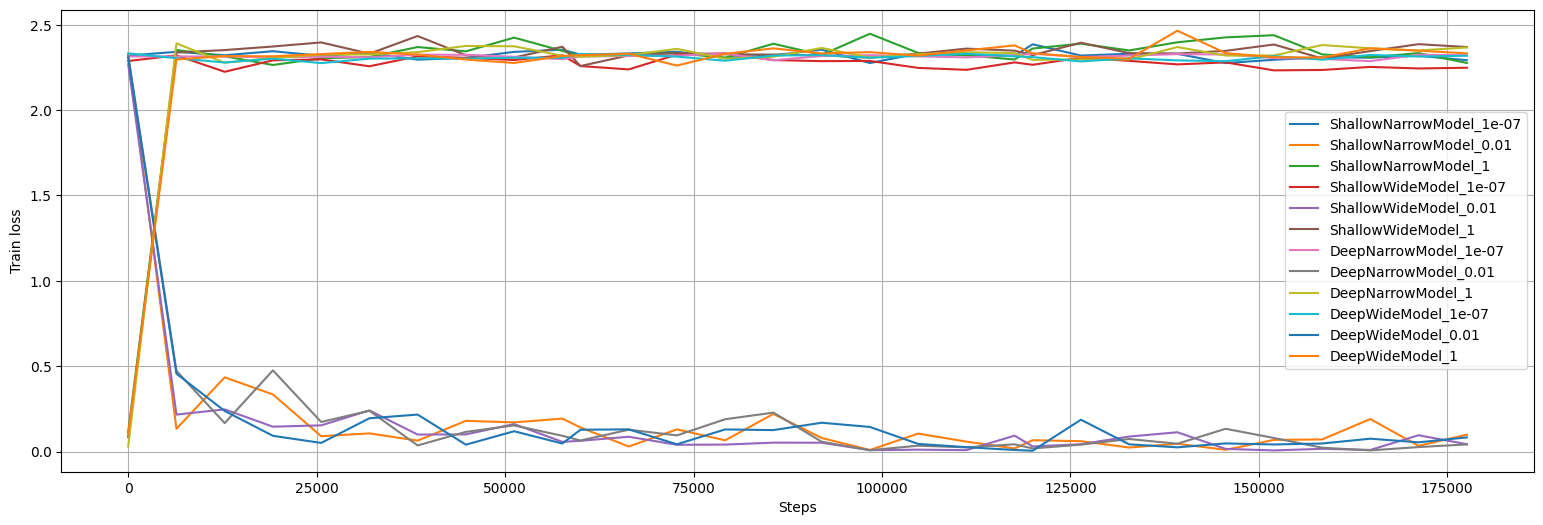

In [45]:
plt.figure(figsize=(19, 6))

for model_key in results:
    plt.plot(results[model_key]['train_counter'], results[model_key]['train_losses'], label=model_key)

plt.legend()
plt.grid()
plt.ylabel("Train loss")
plt.xlabel("Steps")

plt.show()

Answer the following questions:
1. Is it a consistent drop from step to step? No, same steps have a big drop, others a small one or even a rise.
2. Are some architectures significantly better in the beginning than others? Yes, for example deep-wide-1 reduces its lost faster than deep_wide_1e-7
3. Which model is the most unstable during training? I would say shallow-narrow-0.01, but not by a big difference.

Draw a graph where X axis is the time (answers the question: which training step?) And Y axis is the loss for the **test** data set.

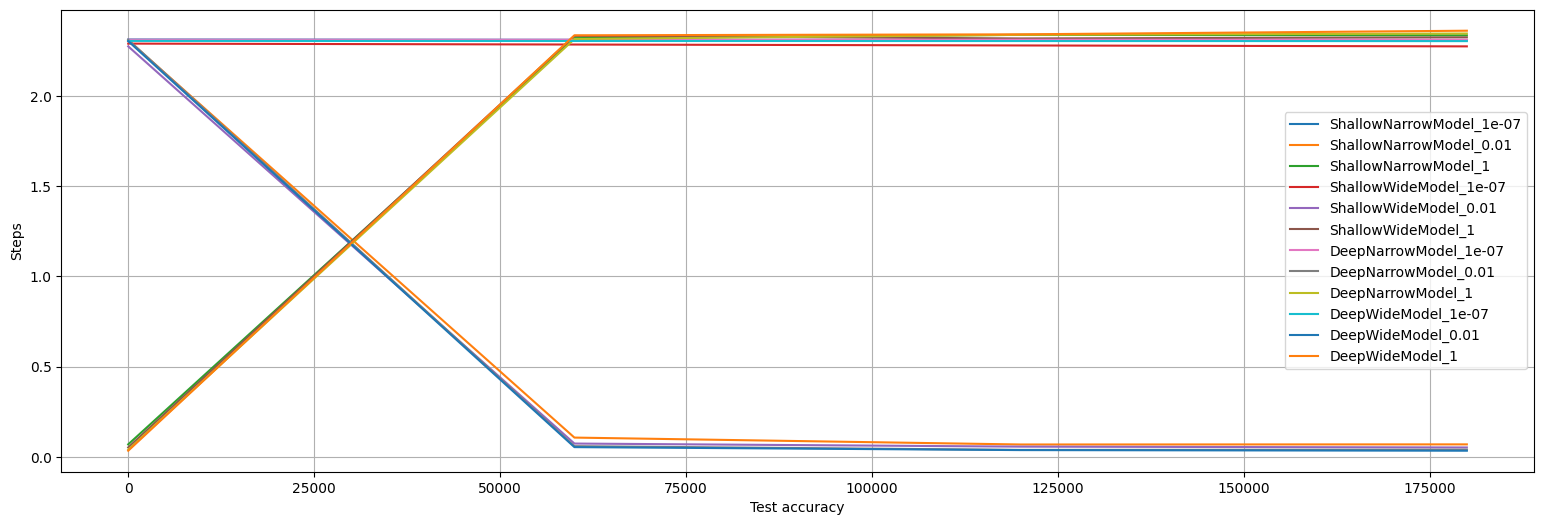

In [48]:
plt.figure(figsize=(19, 6))

for model_key in results:
    plt.plot(results[model_key]['test_counter'], results[model_key]['test_losses'], label=model_key)

plt.legend()
plt.grid()
plt.xlabel("Test accuracy")
plt.ylabel("Steps")
plt.show()

Answer the following questions:    
4. Is it a consistent drop from step to step?  No. Big change between epoch 1-2, small change between 2-3.   
5. Are some architectures significantly better in the beginning than others? Yes. Lr = 1e-7 are almost flat (too small), lr = 0.01 are okey and lr = 1 rise (too big).

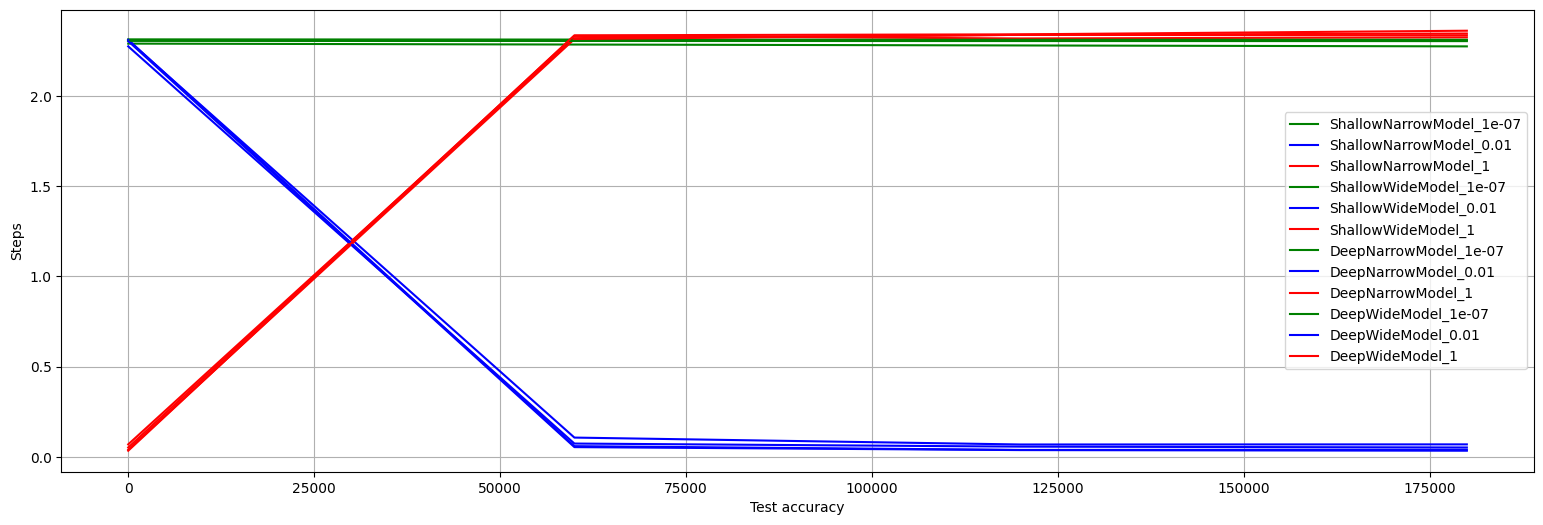

In [50]:
plt.figure(figsize=(19, 6))

for model_key in results:
    lr = model_key.split('_')[-1]
    plt.plot(results[model_key]['test_counter'], results[model_key]['test_losses'], label=model_key, c = 'red' if lr == '1' else 'blue' if lr == '0.01' else 'green' )

plt.legend()
plt.grid()
plt.xlabel("Test accuracy")
plt.ylabel("Steps")
plt.show()


Draw a graph (scatter plot) where the X axis is the number of model parameters, and the Y axis is the accuracy that the model achieves on the test set.

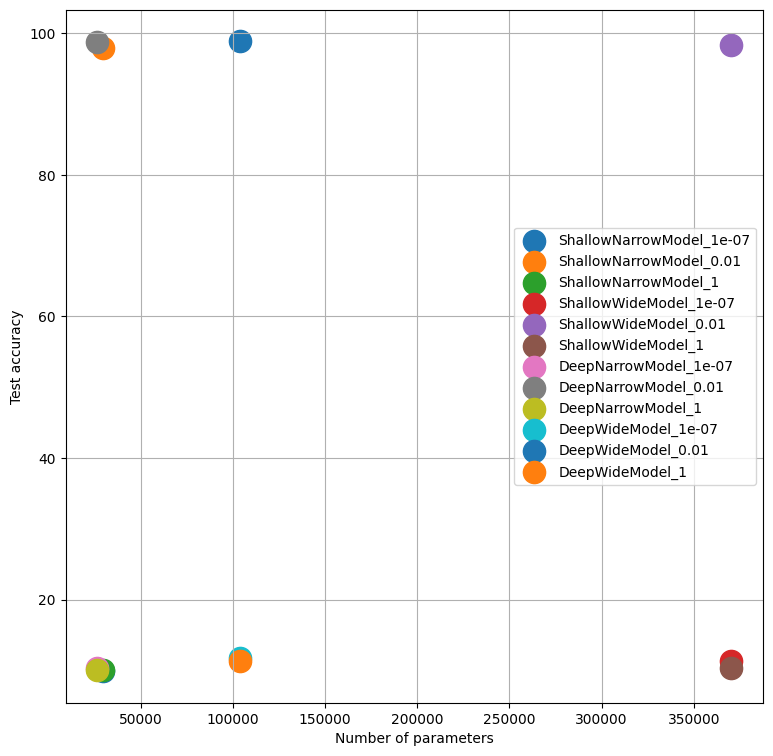

In [52]:
plt.figure(figsize=(9, 9))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.scatter(results[model_key]['number_of_parameters'], results[model_key]['test_accuracy'], label=model_key, s=256)

plt.legend()
plt.grid()
plt.ylabel("Test accuracy")
plt.xlabel("Number of parameters")
plt.show()

Answer the following questions:  
6. What is the best model? Between models with high accuray, we choose the one with less parameters (more efficient): deep-narrow-0.01 

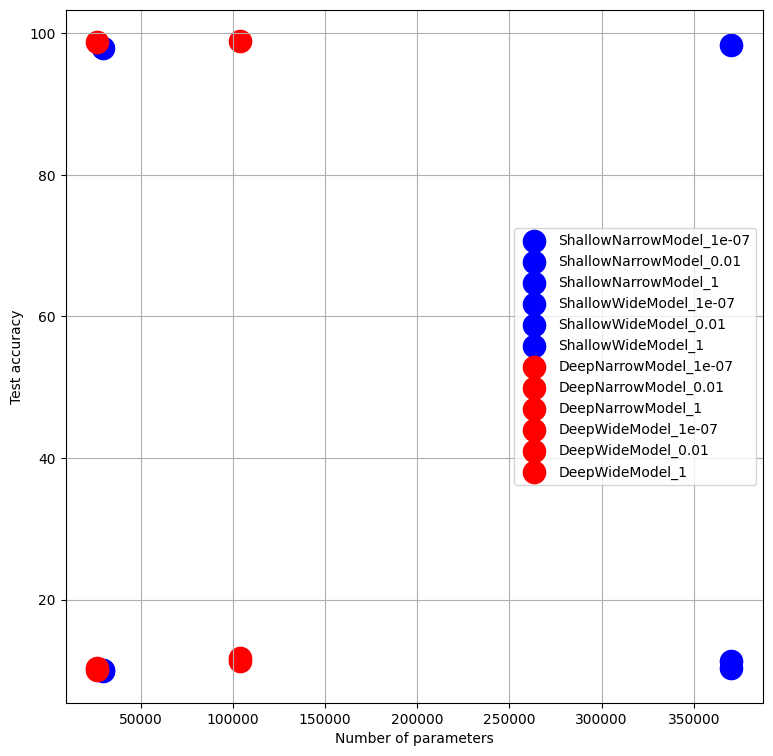

In [54]:
plt.figure(figsize=(9, 9))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.scatter(results[model_key]['number_of_parameters'], results[model_key]['test_accuracy'], label=model_key, s=256,
               c = 'red' if model_key.startswith('Deep') else 'blue')

plt.legend()
plt.grid()
plt.ylabel("Test accuracy")
plt.xlabel("Number of parameters")
plt.show()

7. How succesful are the deep models compared to the shallow models? We have the same amount of successfull models (high accuracy) for each class, but deep models achieve this with less parameters, so they are more efficient.

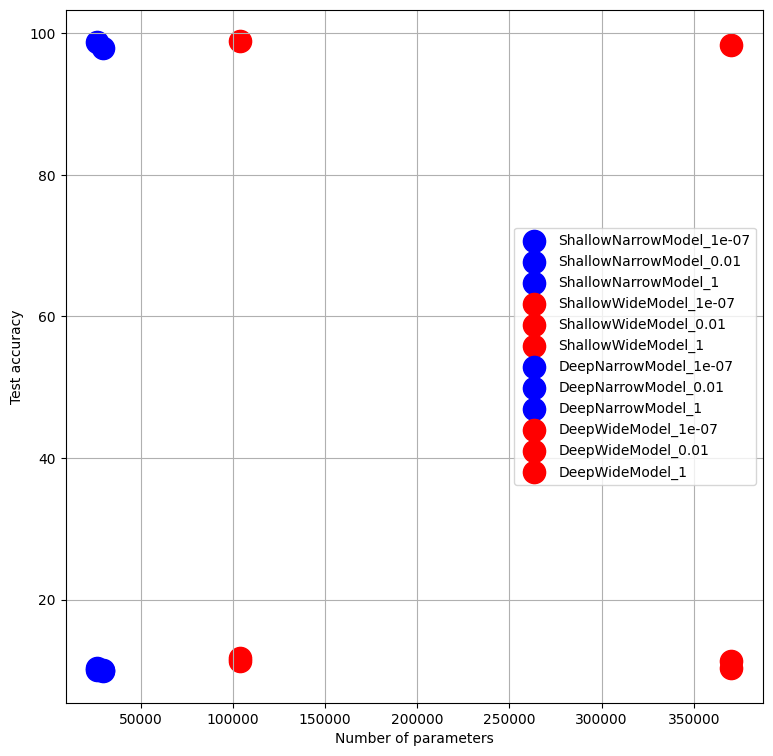

In [56]:
plt.figure(figsize=(9, 9))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.scatter(results[model_key]['number_of_parameters'], results[model_key]['test_accuracy'], label=model_key, s=256,
               c = 'red' if 'Wide' in model_key else 'blue')

plt.legend()
plt.grid()
plt.ylabel("Test accuracy")
plt.xlabel("Number of parameters")
plt.show()

8. How succesful are the wide models compared to the narrow ones? Narrow models are more efficient.

#### Task h) - Evaluation on an unseen set of data

Download the evaluation data set from the following link: http://zver6.zesoi.fer.hr:18080/labos_oi/submission_z1.zip

You can download an example of a file to be generated from: http://zver6.zesoi.fer.hr:18080/labos_oi/zad1_submission_sample.csv

Determine the predictions of your model over this set, and put them on Moodle.

In [ ]:
best_model = DeepNarrowModel()
best_model = best_model.to(device)
optimizer = optim.SGD(best_model.parameters(), lr=0.01, momentum=0.9)

train_losses, train_counter, test_losses, test_counter, test_accuracy = train_network(best_model, train_loader, test_loader, device)

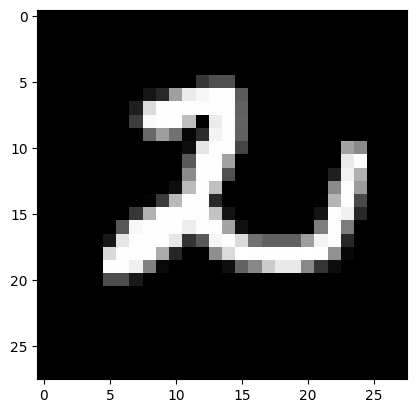

2


In [125]:
img = transform(cv2.imread(f'./submission_z1/submission_z1/zad1_{1}.png', cv2.IMREAD_GRAYSCALE))

fig = plt.figure()
plt.imshow(img1[0], cmap='gray', interpolation='none')
plt.show()

with torch.no_grad():
    print(best_model(img1.unsqueeze(0)).argmax().item())

In [138]:
import csv

transform=torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
                                     

best_model.eval()
with open('zad1_submission.csv', 'a', newline='') as f:
    with torch.no_grad():
        writer = csv.writer(f, delimiter=';')
        # Write the header
        writer.writerow(["image_name", "true_label"])
        for i in range(100):
            img = transform(cv2.imread(f'./submission_z1/submission_z1/zad1_{i}.png', cv2.IMREAD_GRAYSCALE))
            label = best_model(img.unsqueeze(0)).argmax().item() # model is expecting extra dimension for batch
            writer.writerow([f'zad1_{i}.png', label])

## Task 2 - Finding the digits in the image and classifying the digits found

The second task is to expand upon what was learned in the first task. The problem is extended - instead of classifying handwritten digits, our problem now is finding the handwritten digits in the image **and** classify them.

As in the previous exercise, the given parts of the code needed to complete the exercise are given, and it is up to you to complete the missing parts.

#### Dataset

In order to be able to train a model for classifying and detecting an object in an image, we must have an appropriate dataset. We use the existing MNIST dataset, and modify it by placing an original MNIST sample at a random position on a blank image. The following code generates such samples, returning the modified image, the category label, and the digit position in the image (*bounding box*).

In [409]:
class PositionMNIST(Dataset):

    def __init__(self, image_size=128, transform=None, train_set=False):
        self.image_size = image_size
        self.transform = transform

        self.set = torchvision.datasets.MNIST('./files/', train=train_set, download=True)
        self.position_cache = [-1] * len(self.set)

    def __len__(self):
        return len(self.set)

    def __getitem__(self, idx):
        if self.position_cache[idx] == -1:
            x_pos = int(np.random.uniform(0, self.image_size-29))
            y_pos = int(np.random.uniform(0, self.image_size-29))
            self.position_cache[idx] = (x_pos, y_pos)

        x_pos, y_pos = self.position_cache[idx]

        canvas = np.zeros((self.image_size, self.image_size, 1), dtype=np.uint8)
        canvas[y_pos:(y_pos+28), x_pos:(x_pos+28), 0] = self.set[idx][0]

        x_pos = float(x_pos)
        y_pos = float(y_pos)

        if self.transform is not None:
            canvas = self.transform(canvas)

        return canvas, self.set[idx][1], torch.tensor([x_pos, y_pos, x_pos+28, y_pos+28], dtype=torch.float)

In [411]:
batch_size_train = 128
batch_size_test = 128
image_size = 128

train_set = PositionMNIST(train_set=True, image_size=image_size, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

test_set = PositionMNIST(train_set=False, image_size=image_size, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

In [413]:
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=True)

#### Task a) - Data visualization

Take one sample using a data loader and visualize it. Let the class and location in the title of the image.

In [419]:
idx, (img, label, pos) = next(enumerate(train_loader))

print(pos.shape)
print(img.shape)
print(label.shape)

torch.Size([128, 4])
torch.Size([128, 1, 128, 128])
torch.Size([128])


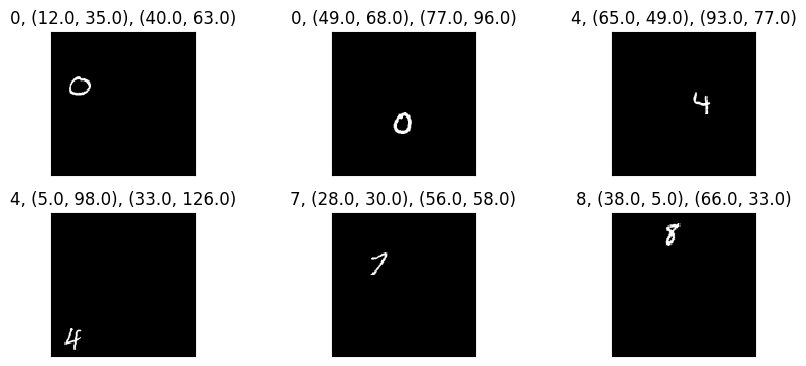

In [421]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_label, example_positions) = next(examples)

fig = plt.figure(figsize=(9, 4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    # -----
    plt.imshow(example_data[i][0], cmap='grey', interpolation='none')
    top_left = (example_positions[i][0].item(), example_positions[i][1].item())
    botton_right = (example_positions[i][2].item(), example_positions[i][3].item())
    plt.title(f'{example_label[i].item()}, {top_left}, {botton_right}')
    # -----
    plt.xticks([])
    plt.yticks([])

plt.show()


#### Task b) - Helper functions

Complement the helper functions for training neural networks according to the principle learned in Task 1. The fundamental difference between the helper function from the previous task and the helper function in this task are:

1. Data handling (there are more data here)
2. We are solving another problem, so we need a different loss function.

The loss function in this case will consist of two parts - a loss for classification that we are already familiar with, and an average squared error (*mean squared error*) for determining the position. Loss will count as:

$ \mathcal{L} = \text{NLLLoss}(\text{classification output}, \text{target)} + \frac{(x_1 - \hat{x}_1)^2 + (y_1 - \hat{y}_1)^2 + (x_2 - \hat{x}_2)^2 + (y_2 - \hat{y}_2)^2}{128 \cdot 128}  $

Where $x$ and $y$ are the exact positions of the object in the image, and $\hat{x}$ and $\hat{y}$ are the model-determined positions of the object.

In [496]:
def train_step(train_loader, epoch, device, verbose=True):
    train_losses = []
    train_counter = []

    network.train()

    for batch_idx, (data, target, position) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        position = position.to(device)
        # -----
        pred_class, pred_bbox = network(data)
        loss = F.nll_loss(pred_class, target, reduction = 'sum') + F.mse_loss(pred_bbox, position, reduction='sum') / (128 * 128)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # -------

        if batch_idx % log_interval == 0:
            if verbose:
                print('Train Epoch: {:5d} [{:5d}/{:5d} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item()))

            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

    return train_losses, train_counter

By the same principle from task 1, complete the model evaluation function. In this case, we measure 3 things: the loss itself, the accuracy of the classification, and especially the loss for detection.

In [498]:
def test(test_loader, device, verbose=True):
    network.eval()

    test_loss_clsf = 0
    test_loss_bbox = 0
    correct = 0
    with torch.no_grad():
        for data, target, position in test_loader:
            data = data.to(device)
            target = target.to(device)
            position = position.to(device)
            # ----
            cls_out, pos_out = network(data)
            test_loss_clsf += F.nll_loss(cls_out, target, reduction='sum').item()
            test_loss_bbox += F.mse_loss(pos_out, position, reduction='sum').item() / (128 * 128)
            target_out = cls_out.argmax(dim=1)
            correct += target_out.eq(target.view_as(target_out)).sum().item()
            # ----

    test_loss_clsf /= len(test_loader.dataset)
    test_loss_bbox /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)


    if verbose:
        print('\n[Test] Classification: Avg. loss: {:.4f}, Accuracy: {:5d}/{:5d} ({:2.2f}%) | Object detection: Avg. loss: {:.4f}\n'.format(
            test_loss_clsf,
            correct,
            len(test_loader.dataset),
            100. * correct / len(test_loader.dataset),
            test_loss_bbox))

    return test_loss_clsf, test_accuracy, correct, test_loss_bbox

The helper function for conducting the experiments from the previous task can be used to monitor additional metrics. Expand this feature for this task.

In [500]:
def train_network(network, train_loader, test_loader, device='cpu'):
    train_losses = []
    train_counter = []
    test_losses_clsf = []
    test_accuracies = []
    test_losses_bbox = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    # -----
    # Initial evaluation (before training) on the test set:
    test_loss_clsf, test_accuracy, correct, test_loss_bbox = test(test_loader, device)
    test_losses_clsf.append(test_loss_clsf)
    test_accuracies.append(test_accuracy)
    test_losses_bbox.append(test_loss_bbox)
    # ----------

    for epoch in range(1, n_epochs + 1):
        # ---------
        new_train_losses, new_train_counter = train_step(train_loader, epoch, device)
        test_loss_clsf, test_accuracy, correct, test_loss_bbox = test(test_loader, device)
        train_losses.extend(new_train_losses)
        train_counter.extend(new_train_counter)
        test_losses_clsf.append(test_loss_clsf)
        test_accuracies.append(test_accuracy)
        test_losses_bbox.append(test_loss_bbox)
        # ---------

    # ---------
    test_losses_total = [clsf + bbox for clsf, bbox in zip(test_losses_clsf, test_losses_bbox)]
    # -----------

    return train_losses, train_counter, test_losses_clsf, test_accuracies, test_losses_bbox, test_counter

## Conducting experiments and result analysis

#### Task c) - Creating a model for classification and detection

As in the previous task, you need to adjust the parameters first. The parameters are the same, but let's repeat:
* n_epochs - number of experiment epochs
* learning_rate - learning rate
* log_interval - number of steps between two prints during training (printing only happens if the function is called with the verbose = True argument)
* device - a mark on which device the experiment is performed; "miracles" for GPU, "cpu" for CPU

In [429]:
n_epochs = 3
learning_rate = 0.0005
momentum = 0.9
log_interval = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

The fundamental difference between the model architecture of this task and the model architecture from the previous task is the number of outputs. The previous neural network had 10 output neurons - each for one class. This neural network has 14 outputs - 10 for each class for the classification problem and 4 for each coordinate of the resulting bounding box of the object.

Based on the experience from Task 1, complete the following model to solve the problem:

In [510]:
class Net(nn.Module):
    def __init__(self, image_size=128, position_size=4):
        super(Net, self).__init__()
        self.image_size = image_size
        self.position_size = position_size

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=5)
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(in_features=30*12*12, out_features=500)
        self.cls_fc = nn.Linear(in_features=500, out_features=10)
        self.pos_fc = nn.Linear(in_features=500, out_features=4)

    def forward(self, data):
        # img input branch
        # data (128, 1, 128, 128) (batch_size, channels, H, W)
        data = self.conv1(data) # (128, 10, 124, 124)
        data = self.relu(data) 
        data = self.pool(data) # (128, 10, 62, 62)
        
        data = self.conv2(data) # (128, 20, 58, 58)
        data = self.relu(data)
        data = self.pool(data) # (128, 20, 29, 29)
        
        data = self.conv3(data)  # (128, 30, 24, 24)
        data = self.relu(data)
        data = self.pool(data) # (128, 30, 12, 12)
        
        data = data.view(data.shape[0], -1) # (128, 30 * 12 * 12)
        
        data = self.fc1(data) # (128, 500)
        data = self.relu(data)
        data = self.dropout(data)
        
        # Classification branch
        cls_logits = self.cls_fc(data) # (128, 10)
        cls_out = F.log_softmax(cls_logits, dim=1)

   
        # Detection branch: get bbox coordinates
        pos_out = self.pos_fc(data) # (128, 4)
        pos_out = self.relu(pos_out)
        
        return cls_out, pos_out

In [512]:
network = Net(image_size).to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [514]:
number_of_params = get_number_of_model_parameters(network)
print("Number of parameters in the model:", number_of_params)

Number of parameters in the model: 2187824


In [516]:
train_losses, train_counter, test_losses_clsf, test_accuracies, test_losses_bbox, test_counter = train_network(network, train_loader, test_loader, device)


[Test] Classification: Avg. loss: 2.3031, Accuracy:   993/10000 (9.93%) | Object detection: Avg. loss: 1.2139

Train Epoch:     1 [    0/60000 ( 0%)]	Loss: 453.457275
Train Epoch:     1 [12800/60000 (21%)]	Loss: 312.243286
Train Epoch:     1 [25600/60000 (43%)]	Loss: 235.767426
Train Epoch:     1 [38400/60000 (64%)]	Loss: 205.021057
Train Epoch:     1 [51200/60000 (85%)]	Loss: 125.368759

[Test] Classification: Avg. loss: 0.6533, Accuracy:  7902/10000 (79.02%) | Object detection: Avg. loss: 0.0448

Train Epoch:     2 [    0/60000 ( 0%)]	Loss: 100.998047
Train Epoch:     2 [12800/60000 (21%)]	Loss: 92.622810
Train Epoch:     2 [25600/60000 (43%)]	Loss: 74.202248
Train Epoch:     2 [38400/60000 (64%)]	Loss: 50.536358
Train Epoch:     2 [51200/60000 (85%)]	Loss: 54.850529

[Test] Classification: Avg. loss: 0.2842, Accuracy:  9100/10000 (91.00%) | Object detection: Avg. loss: 0.0177

Train Epoch:     3 [    0/60000 ( 0%)]	Loss: 44.056076
Train Epoch:     3 [12800/60000 (21%)]	Loss: 81.566

In [517]:
torch.save(network.state_dict(), 'modelz2.pth')
results_z2 = {
    'train_losses':train_losses,
    'train_counter':train_counter,
    'test_losses_clsf':test_losses_clsf,
    'test_accuracies':test_accuracies, 
    'test_losses_bbox':test_losses_bbox, 
    'test_counter':test_counter
}
with open('modelz2_results.pkl', 'wb') as file:
    pickle.dump(results_z2, file)

**Visualization**

Visualize all the metrics on the following graph: train_losses, test_losses_total, test_losses_clsf, and test_losses_bbox. Watch what is on your x-axis!

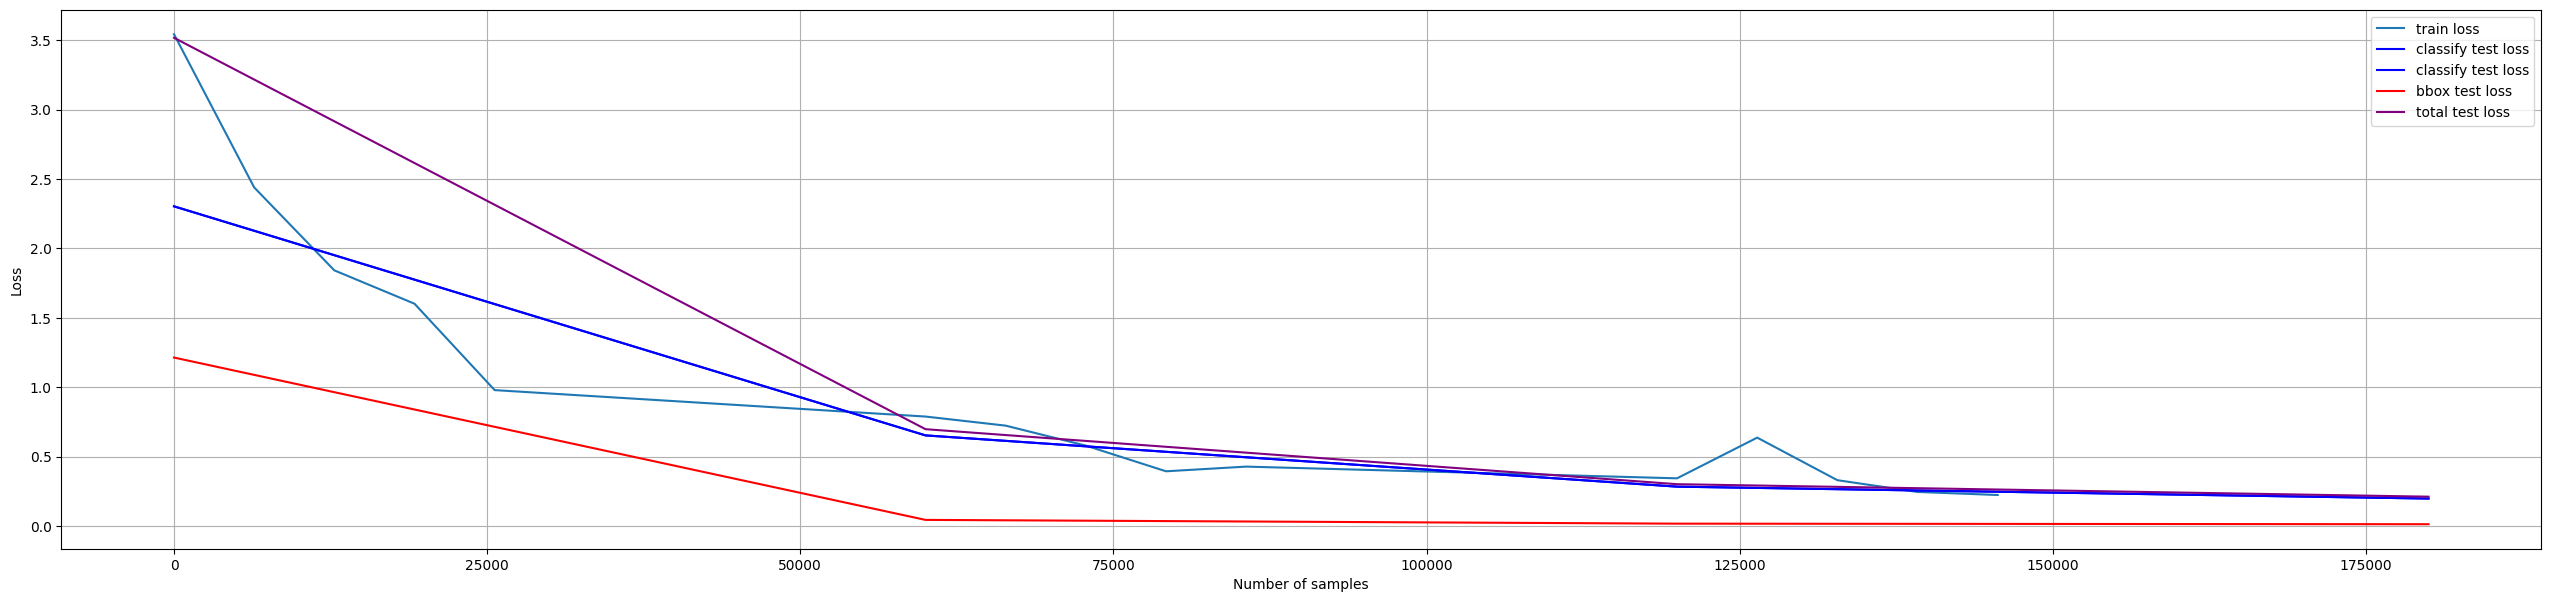

In [520]:
test_losses_total = np.array(test_losses_clsf) + np.array(test_losses_bbox)

fig = plt.figure(figsize=(32, 7))
# ----
plt.plot(train_counter, np.array(train_losses) / 128, label='train loss') # Forgot to devide by the batch size before
plt.plot(test_counter, test_losses_clsf, label='classify test loss', c = 'blue')
plt.plot(test_counter, test_losses_clsf, label='classify test loss', c = 'blue')
plt.plot(test_counter, test_losses_bbox, label='bbox test loss', c = 'red')
plt.plot(test_counter, test_losses_total, label='total test loss', c = 'purple')
# ----------

plt.legend(loc='upper right')
plt.xlabel('Number of samples')
plt.ylabel('Loss')
plt.grid()
plt.show()

#### Visual inspection - what is your model doing?

Use the following code to see what your model's predictions look like.

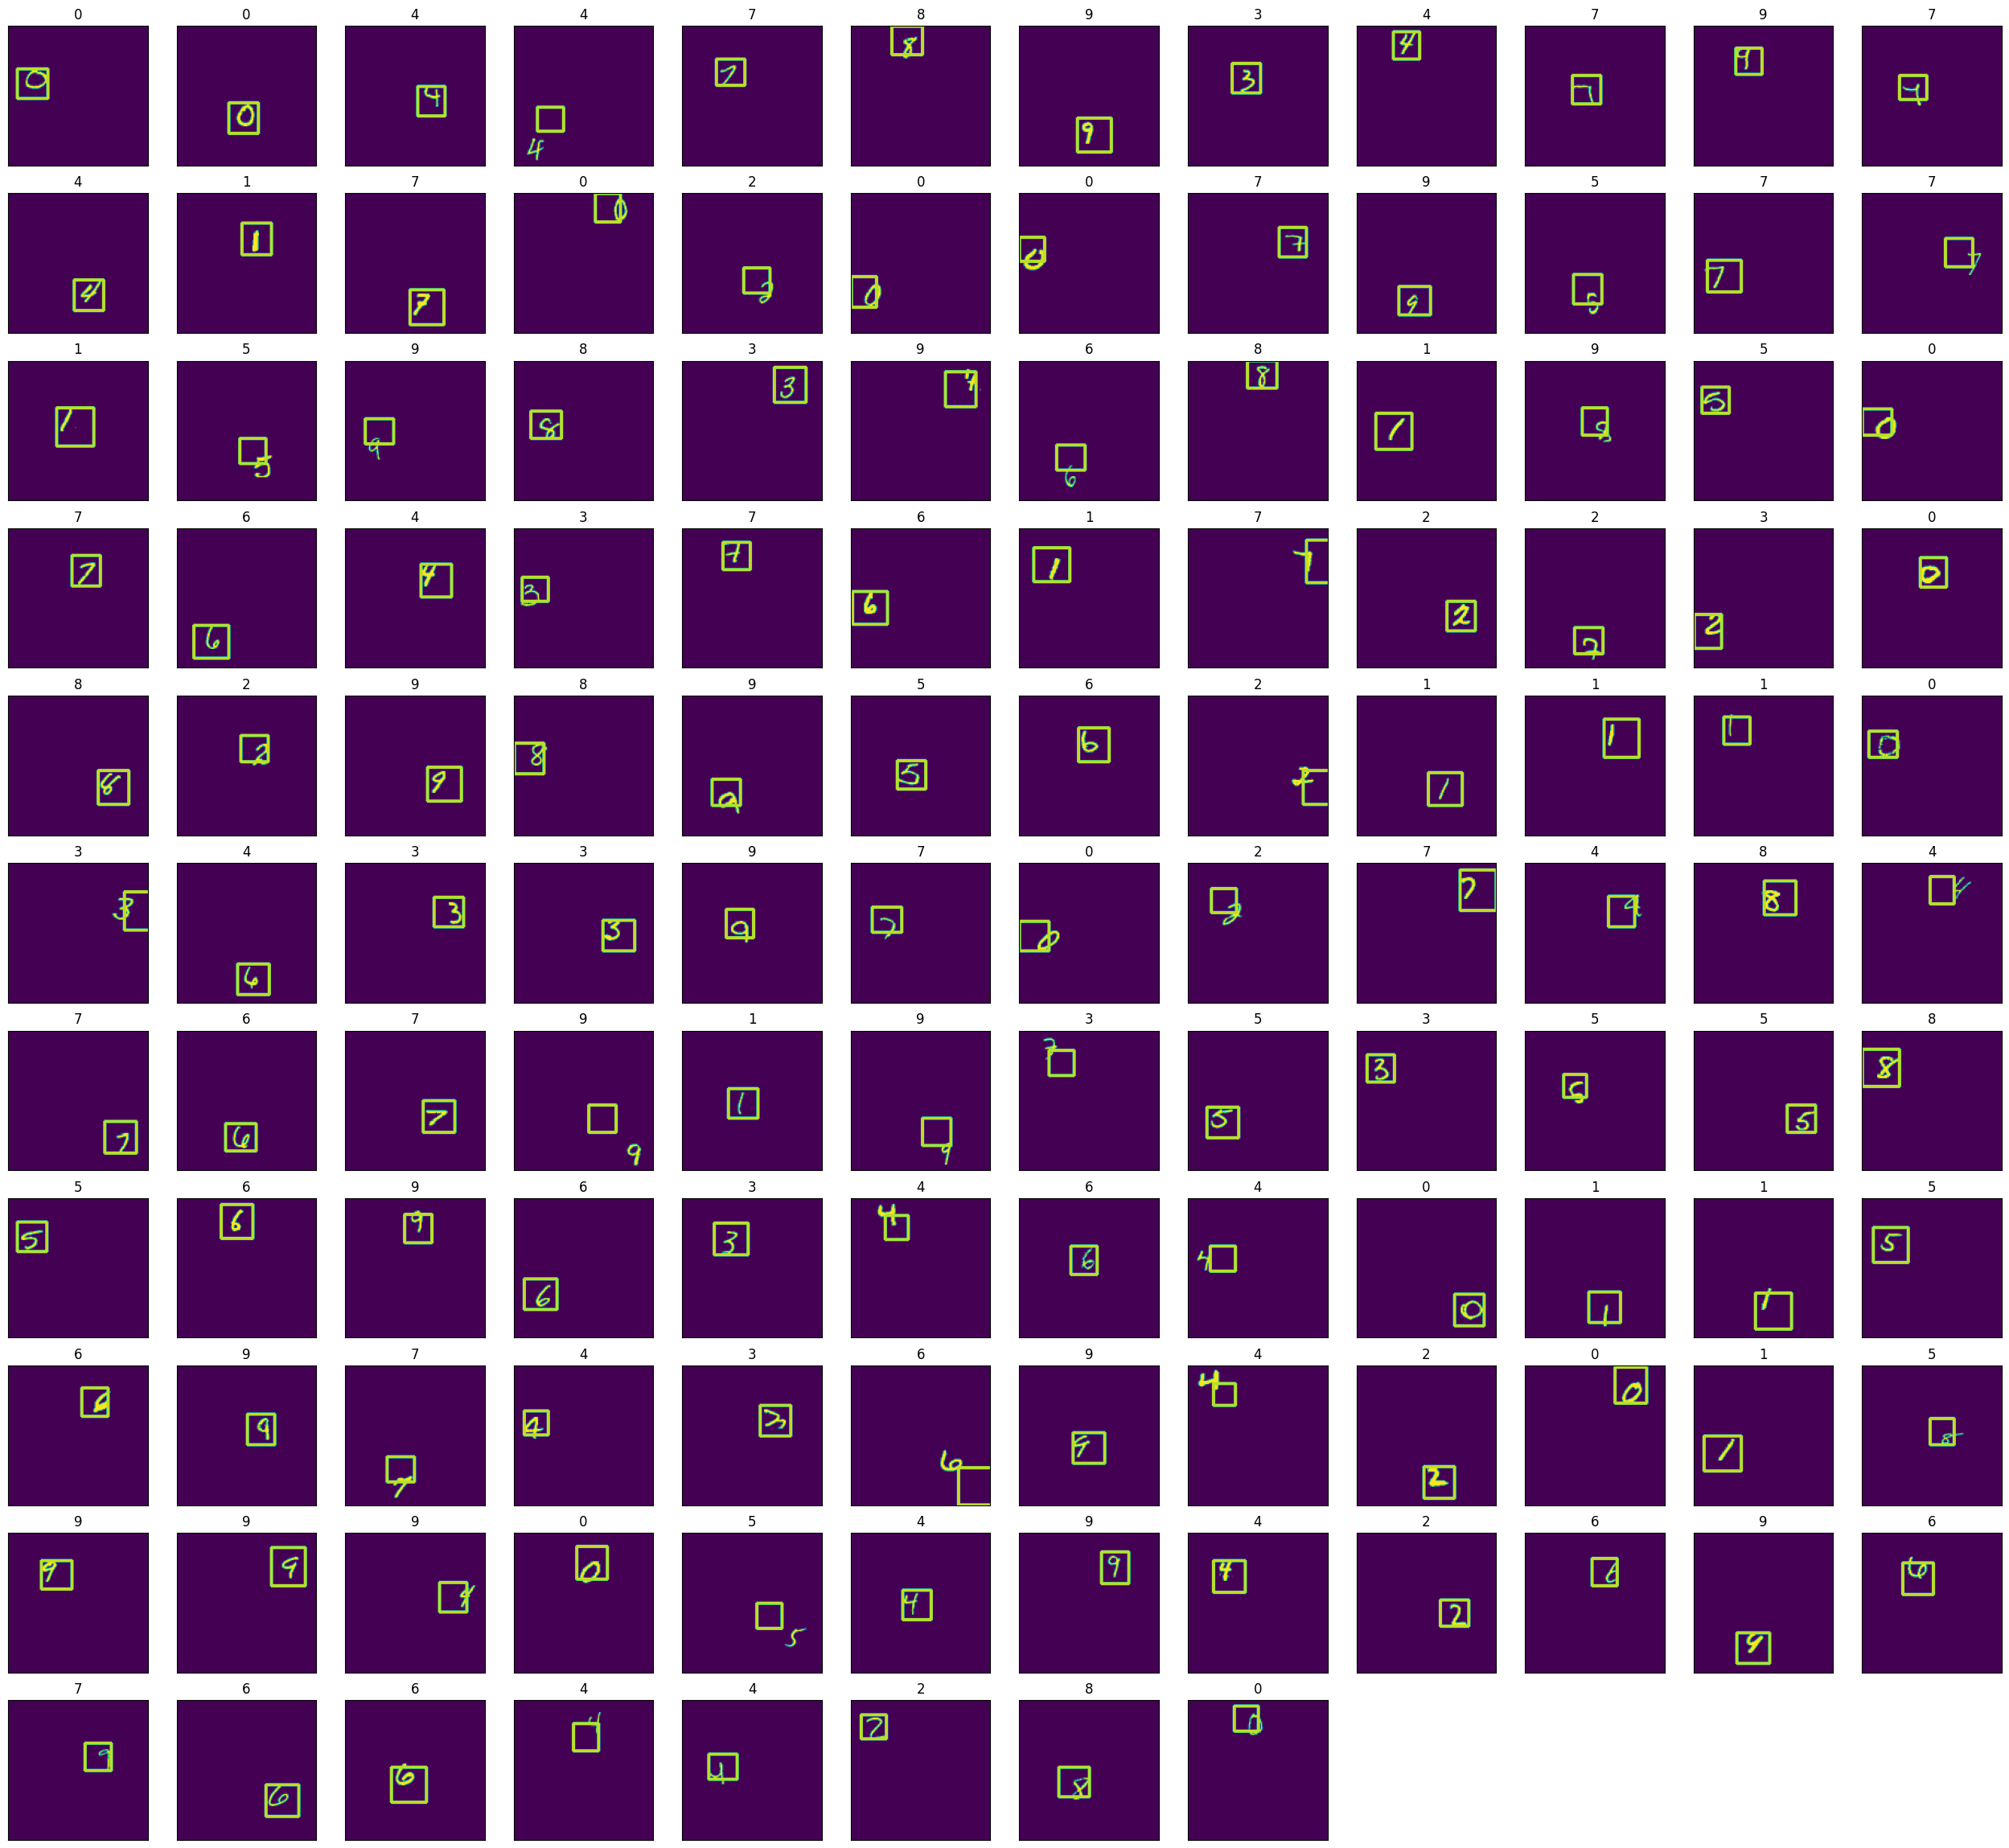

In [522]:
with torch.no_grad():
    clsf_out, pos_out = network(example_data.to(device))

plt.figure(figsize=(32, 32))
for idx in range(0, example_data.shape[0]):
    image = np.array(example_data[idx, 0, ...]).copy()
    x1, y1, x2, y2 = list(
        map(lambda x: int(x.item()), [
            pos_out[idx, 0],
            pos_out[idx, 1],
            pos_out[idx, 2],
            pos_out[idx, 3]
        ])
    )
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (2.5), 2)

    plt.subplot(12, 12, idx+1)
    plt.imshow(image)
    plt.title(np.argmax(clsf_out[idx, ...].cpu()).item())
    plt.xticks([])
    plt.yticks([])
    
plt.show()

Maybe just predicting x1,y1 and compute x2,y2 adding 28 would be better in this case.

#### Task d) - Evaluation on unseen data

Download the evaluation data set from the following link: http://zver6.zesoi.fer.hr:18080/labos_oi/submission_z2.zip

You can download an example of a file to be generated from: http://zver6.zesoi.fer.hr:18080/labos_oi/zad2_submission_sample.csv

Determine the predictions of your model over this set, and put them on Moodle.

In [553]:
transform=torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
                                     

network.eval()
with open('zad2_submission.csv', 'a', newline='') as f:
    with torch.no_grad():
        writer = csv.writer(f, delimiter=';')
        # Write the header
        writer.writerow(["image_name", "true_label", "x1", "y1", "x2", "y2"])
        for i in range(128):
            img = transform(cv2.imread(f'./submission_z2/submission_z2/zad1_{i}.png', cv2.IMREAD_GRAYSCALE))
            cls, bbox = network(img.unsqueeze(0)) # model is expecting extra dimension for batch
            cls = cls[0]
            bbox = bbox[0]
            writer.writerow([
                f'zad1_{i}.png',
                cls.argmax().item(),
                int(bbox[0].item()),
                int(bbox[1].item()),
                int(bbox[2].item()),
                int(bbox[3].item())
            ])